### 사용 패키지 Import

In [1]:
#!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device='cpu'

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### 사용 데이터 경로 

In [11]:
IMAGE_ROOT = './Covid_data_256/train'
DF_RAW = pd.read_csv('./Covid_data_256/updated_train_labels.csv')
DF_RAW

# DF_RAW['labels'] = 0
# DF_RAW.loc[(DF_RAW['human_label']=='typical'),'labels']=1

#negative는 bb가 안생겨서 삭제 
#mask= DF_RAW['human_label'].isin(['negative'])
#DF_RAW = DF_RAW[~mask]

#print(len(DF_RAW['id'].unique())) #사진개수 0~4597
#print(len(DF_RAW['human_label']=="typical"))

,id,dcm_path,xmin,ymin,xmax,ymax,human_label,negative,typical,indeterminate,...,SeriesInstanceUID,ImageInstanceUID,img_shape,width,height,frac_xmin,frac_xmax,frac_ymin,frac_ymax,integer_label
0,000a312787f2,/kaggle/input/siim-covid19-detection/train/577...,2245.91208,591.20528,3340.57370,2352.75472,typical,0,1,0,...,81456c9c5423,000a312787f2,"(3488, 4256)",4256,3488,0.527705,0.784909,0.169497,0.674528,3
1,000a312787f2,/kaggle/input/siim-covid19-detection/train/577...,789.28836,582.43035,1815.94498,2499.73327,typical,0,1,0,...,81456c9c5423,000a312787f2,"(3488, 4256)",4256,3488,0.185453,0.426679,0.166981,0.716667,3
2,000c3a3f293f,/kaggle/input/siim-covid19-detection/train/ff0...,0.00000,0.00000,1.00000,1.00000,negative,1,0,0,...,d8a644cc4f93,000c3a3f293f,"(2320, 2832)",2832,2320,0.000000,0.000353,0.000000,0.000431,2
3,0012ff7358bc,/kaggle/input/siim-covid19-detection/train/9d5...,677.42216,197.97662,1545.21983,1197.75876,typical,0,1,0,...,22897cd1daa0,0012ff7358bc,"(2544, 3056)",3056,2544,0.221670,0.505635,0.077821,0.470817,3
4,0012ff7358bc,/kaggle/input/siim-covid19-detection/train/9d5...,1792.69064,402.55250,2409.71798,1606.91050,typical,0,1,0,...,22897cd1daa0,0012ff7358bc,"(2544, 3056)",3056,2544,0.586613,0.788520,0.158236,0.631647,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9888,ffd9b6cf2961,/kaggle/input/siim-covid19-detection/train/7ee...,2197.38566,841.07361,2513.80265,1292.71119,typical,0,1,0,...,668a64e3a5fa,ffd9b6cf2961,"(2388, 3050)",3050,2388,0.720454,0.824198,0.352208,0.541336,3
9889,ffdc682f7680,/kaggle/input/siim-covid19-detection/train/a0c...,1005.81250,1584.67711,1668.04163,2360.51048,typical,0,1,0,...,ccf363aa080f,ffdc682f7680,"(3488, 4256)",4256,3488,0.236328,0.391927,0.454323,0.676752,3
9890,ffdc682f7680,/kaggle/input/siim-covid19-detection/train/a0c...,2729.27083,332.26044,4225.52099,2936.84378,typical,0,1,0,...,ccf363aa080f,ffdc682f7680,"(3488, 4256)",4256,3488,0.641276,0.992839,0.095258,0.841985,3
9891,ffe942c8655f,/kaggle/input/siim-covid19-detection/train/7d8...,755.52522,144.33069,1183.39442,692.09119,typical,0,1,0,...,431ee249d16b,ffe942c8655f,"(1140, 1387)",1387,1140,0.544719,0.853204,0.126606,0.607098,3


In [15]:
#결측치(null) 확인
DF_RAW.isnull().sum()

id                   0
dcm_path             0
xmin                 0
ymin                 0
xmax                 0
ymax                 0
human_label          0
negative             0
typical              0
indeterminate        0
atypical             0
StudyInstanceUID     0
SeriesInstanceUID    0
ImageInstanceUID     0
img_shape            0
width                0
height               0
frac_xmin            0
frac_xmax            0
frac_ymin            0
frac_ymax            0
integer_label        0
dtype: int64

In [13]:
# 각 Label별 개수
print(len(DF_RAW.loc[DF_RAW['human_label'] == "negative"])) 
print(len(DF_RAW.loc[DF_RAW['human_label'] == "typical"])) 
print(len(DF_RAW.loc[DF_RAW['human_label'] == "atypical"])) 
print(len(DF_RAW.loc[DF_RAW['human_label'] == "indeterminate"])) 

1736
6034
629
1494


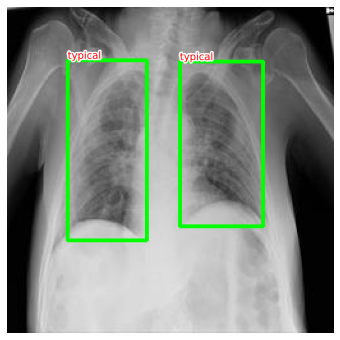

In [21]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df 
        self.unique_images = df['id'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix] #파일 고유명
        image_path = f'{self.root}/{image_id}.jpg' #이미지의 전체경로
        #print(image_id)
        #print(image_path)
        image = cv2.imread(image_path, 1)[...,::-1] # convert BGR to RGB
        #print(len(image))
        #print(image)
        h, w, _ = image.shape # h=높이, w= 너비 _=채널(depth)
        #print(h,w,_)
        df = self.df.copy() #이미지 변형방지를 위한 복사
        df = df[df['id'] == image_id] 
        boxes = df['frac_xmin,frac_ymin,frac_xmax,frac_ymax'.split(',')].values #csv 에서 정규화 되어있는 값 가져오기
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist() #정규화된 값 ->  256*256 전환->리스트 담기
        #print(boxes)
        classes = df['human_label'].values.tolist() #분류된 box의 라벨명->리스트
        #print(classes) 
        return image, boxes, classes, image_path
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[0] #image(RGB), boxes(여러개), lablename, path
#print(im)
#print(type(bbs))
#print(ds[2])
show(im, bbs=bbs, texts=clss, sz=6)

#(XMin,Ymin)-> 이미지 좌측 하단 좌표의 정규화 값
#(XMax,Ymax)-> 이미지 우측 상단 좌표의 정규화 값
#네 값으로 bb 생성

### Region Proposal 

#### extract 수정해야함

In [22]:
def extract_candidates(img): 
    img_lbl, regions = selectivesearch.selective_search(img, scale=256, min_size=20)
    img_area = np.prod(img.shape[:2])#np.prod ->요소들의 곱 반환
    #print(img_area)
    #print(img.shape[:2]) -> W,H -> W*H =256*256
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        #if r['size'] < (0.00001524*img_area): continue # 너무 작은 값 pass
        if r['size'] < (0.05*img_area): continue # 너무 작은 값 pass
        if r['size'] > (1*img_area): continue #너무 큰 값 pass
        x, y, w, h = r['rect']
        #print(x,y,w,h)
        candidates.append(list(r['rect']))
    return candidates

In [23]:
def extract_iou(boxA, boxB, epsilon=1e-5):
    #두 영역의 교집합 구하기
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height #교집합 넓이
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]) #a의 넓이
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1]) #b의 넓이
    area_combined = area_a + area_b - area_overlap #합집합 넓이
    iou = area_overlap / (area_combined+epsilon) # 교집합/합집합 ->비율
    return iou

### 예시

Best IoU: 0.4112914606392418


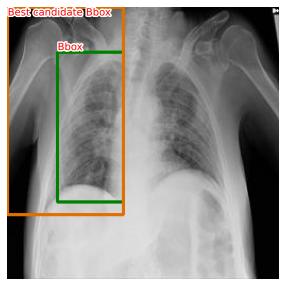

In [29]:
#예시
(im, bbs, labels, fpath) = ds[0]
H, W, _ = im.shape
candidates = extract_candidates(im)
candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])  # ds에서 Region proposal된 모든 bbs 가져옴

ious, rois, clss, deltas, best_ious = [], [], [], [], []
temp_best_bbs = []
ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T

for jx, candidate in enumerate(candidates):
    cx,cy,cX,cY = candidate
    candidate_ious = ious[jx]  #Region proposal된 모든 bbs 반복
    #print(candidate_ious)
    best_iou_at = np.argmax(candidate_ious)  #best candidate iou is taken (index) ~ 항상 0나옴
    best_iou = candidate_ious[best_iou_at]   #gets the best score here
    #print(best_iou)
    best_ious.append(best_iou)
    best_bb = _x,_y,_X,_Y = bbs[best_iou_at] # gets the target label bounding box where there is the highest iou
    #print(best_bb)
    temp_best_bbs.append(best_bb)
    if best_iou > 0.3: clss.append(labels[best_iou_at]) # 30퍼센트이상 포함되어야함
    else : clss.append('negative')
    delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])  #값 정규화
    deltas.append(delta)
    #print(clss)
    rois.append(candidate / np.array([W,H,W,H]))

best_ious_at = np.argmax(best_ious)
print("Best IoU:", best_ious[best_ious_at])


best_candidate = candidates[best_ious_at]
best_bbs = temp_best_bbs[best_ious_at]

# Example of df[15]
candidates = extract_candidates(im)
show(im, bbs = [best_bbs, best_candidate], confs= [0,0.5], texts = ['Bbox', 'Best candidate Bbox'])

(38, 4)
<class 'list'>


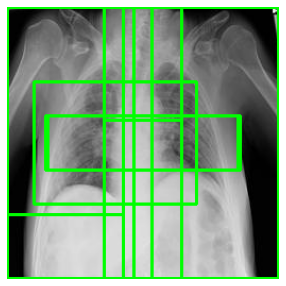

In [30]:
# Region Proposal 결과
candidates = extract_candidates(im)
print(np.shape(candidates))
print(type(candidates))
show(im, bbs = candidates)

In [ ]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
#N = 1
N = 1
for ix, (im, bbs, labels, fpath) in enumerate(ds): 
    if(ix==N):
        break
    print(ix)
    H, W, _ = im.shape #이미지의 높이,너비,채널
    #print(H,W,_)
    #사용함수 : extract_candidates(img)
    candidates = extract_candidates(im)  
    #print(candidates)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates]) #x,y ->bb의 좌상단 좌표
    #print(candidates)
    ious, rois, clss, deltas = [], [], [], []
    #사용함수 : extract_iou(boxA, boxB, epsilon=1e-5)
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    #print(ious)
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        #print(cx,cy,cX,cY)
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('negative')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H]) #정규화
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [ ]:
#targets = pd.DataFrame(flatten(CLSS), columns=['human_label'])
label2target = {l:t+1 for t,l in enumerate(DF_RAW['human_label'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

print("The label to target values dictionary formed is:" ,label2target)

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    #RGB to BGR
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds

### 데이터 셋 모델 정의

In [ ]:
class FRCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1] # convert BGR to RGB
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
        return image, rois, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, labels, deltas

In [ ]:
# Data의 90% ->Train 나머지 Test
n_train = 8*len(FPATHS)//10
print(n_train)
train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

### Resize 

In [ ]:
for input, rois, rixs, labels, deltas in train_loader:
    print(input.shape)
    print(labels) # labels 값이 각 batch_size마다 다름
    break

In [ ]:
from torchvision.ops import RoIPool
class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        rawnet = torchvision.models.vgg16_bn(pretrained=True)#backbone
        for param in rawnet.features.parameters():
            param.requires_grad = True
        self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
        self.roipool = RoIPool(7, spatial_scale=14/224)
        feature_dim = 512*7*7
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, input, rois, ridx):
        res = input
        res = self.seq(res)
        rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)
        res = self.roipool(res, rois)
        feat = res.view(len(res), -1)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat) # .view(-1, len(label2target), 4)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [ ]:
frcnn = FRCNN().to(device)
print(frcnn)

### 모델 학습

In [ ]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [ ]:
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [ ]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

n_epochs = 10

In [ ]:
log = Report(n_epochs)
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')
        
    log.report_avgs(epoch+1)

In [ ]:
# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [ ]:
# bb 생성의 loss
log.plot_epochs('trn_loc_loss,val_loc_loss'.split(','))

In [ ]:
log.plot_epochs('trn_regr_loss,val_regr_loss'.split(','))

In [ ]:
log.plot_epochs('trn_acc,val_acc'.split(','))

### Test

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image
def test_predictions(filename):
    #img = cv2.resize(np.array(Image.open(filename)), (224,224))
    #img = cv2.resize(cv2.imread(filename, 1)[...,::-1], (224,224))
    img = cv2.resize(cv2.imread(filename, 1), (224,224))
    #print(img.shape)
    candidates = extract_candidates(img)
    #print(candidates)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    #print(candidates)
    input = preprocess_image(img/255.)[None]
    #print(input.shape)
    #print(input)
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
    rixs = np.array([0]*len(rois))
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        frcnn.eval() ##eval() -> gradient 고정
        probs, deltas = frcnn(input, rois, rixs)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
        print(confs, clss, probs, deltas, candidates, bbs)
    bbs = bbs.astype(np.uint16)
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    a= clss.tolist()
    c= len(a)
    label=[]
    for i in range(c):
        result=target2label[a[i]]
        label.append(result)
    print(label)
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('Negative')
        plt.show()
        return
    else:
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
        plt.show()

In [ ]:
i=10
# Test 결과값
print(test_ds[i])
test_predictions(test_ds[i][-1])


#원본과 비교
# ds = OpenImages(df=DF_RAW)
# im, bbs, clss, _ = ds[n_train+i]
# show(im, bbs=bbs, texts=clss, sz=10,title='Original')

In [ ]:
for ix in range(N-n_train):
    print(ix)
    test_predictions(test_ds[ix][-1])